## RQ2 Text Analysis

General plan:
- Follow a similar approach to the Chai-Allah "Data Mining..." paper to create clusters from the data
    - Just use tokenisation first, if 2 big then use lemmatisation
    - for now, just use all words (don't worry about filtering for high frequency words)
    - Use a German version of the word2vec model (see what the baroni one is based on and try to find a German equivalent)
    - use k-means or ward's for the clustering

Steps:
1. Initial Cleaning
2. Language Handling 
3. Tokenisation 
4. Filtering & Lemmatisation (remove stop words, lemmatise, convert to lowercase)
5. Semantic analysis (word2vec)
6. Clustering


In [1]:
# SETUP

# Import packages
import pandas as pd
import numpy as np
import pickle

import spacy 
from langdetect import detect
from deep_translator import GoogleTranslator
from collections import Counter
from gensim.models import KeyedVectors  # requires scipy version 1.12 (anything newer doesn't work)


from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from wordcloud import WordCloud


### Step 1: Initial Cleaning

General text preparation to get the data in a format which works for translation and for use with spacy. Note that I do this separate for class 3, class 4 and 5 together, and class 6 so that the processing steps do not have to be repeated again for RQ3.

Decided not to use the comments as there is no guarantee the comments are an expression of someone's perception about the trail/landscape (they might just be saying the trail looks nice from the original posters description, they might be commenting on the directions, etc)

In [2]:
# STEP 1: LOAD & CLEAN

# Load the master CSV from rq2_step1_data_collection
master = pd.read_csv("./processing/master.csv")

# Add ['None'] to any blank rows
# this is necessary for the next step, but then they will be removed later
master.fillna("['None']", inplace=True)

# Extract classes separately for use in RQ3 (4 and 5 can be together)
master_c3 = master[master["max_class"]==3]
master_c45 = master[(master["max_class"]==4) | (master["max_class"]==5)]
master_c6 = master[master["max_class"]==6]

# Create empty dfs for storing trail descriptions and photo captions for each class
raw_text_c3 = pd.DataFrame()
raw_text_c45 = pd.DataFrame()
raw_text_c6 = pd.DataFrame()

# Extract the description and captitions and combine them into a single column
raw_text_c3["desc_capt"] = master_c3["description text"] + " " + master_c3["photo_captions"]
raw_text_c45["desc_capt"] = master_c45["description text"] + " " + master_c45["photo_captions"]
raw_text_c6["desc_capt"] = master_c6["description text"] + " " + master_c6["photo_captions"]

# Create a list of the class dfs to optimise processing
raw_text_all = [raw_text_c3, raw_text_c45, raw_text_c6]

# Remove all the ['None'] text from each class df
for df in raw_text_all:
    df["desc_capt"] = df["desc_capt"].str.replace(r"\['None'\]", "", regex=True)

# Define special characters to be removed
sp_chars = r"[\[\]'|\\\/+=]"

# Remove defined special characters from each class df
for df in raw_text_all:
    for char in sp_chars:
        df["desc_capt"] = df["desc_capt"].str.replace(sp_chars, "", regex=True)

# This is to address a specific issue in one of the entries (replace with space)
for df in raw_text_all:
    df["desc_capt"] = df["desc_capt"].str.replace(r"\n", " ", regex=True)

# Convert each df to a list
raw_text_c3_list = raw_text_c3["desc_capt"].astype(str).values.tolist()
raw_text_c45_list = raw_text_c45["desc_capt"].astype(str).values.tolist()
raw_text_c6_list = raw_text_c6["desc_capt"].astype(str).values.tolist()

# Create a list of the class listss to optimise processing
raw_text_lists_all = [raw_text_c3_list, raw_text_c45_list, raw_text_c6_list]

# Remove trailing white space
for sublist in raw_text_lists_all:
    for trail in range(len(sublist)):
        sublist[trail] = sublist[trail].rstrip()

# Remove all empty entries
for sublist in raw_text_lists_all:
    sublist[:] = list(filter(None, sublist))

raw_text_c3_list


['Old sawmill',
 'Breite Forstwege und Pfade. Auf halber Strecke kann man im Bergwerkstüble einkehren (Montag Ruhetag)',
 'Rinken - Feldberg-Ort Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto',
 'Rinken - Feldbergerhof',
 'Pforzheim Hohenwart Pforzheim',
 'Möggingen',
 'Istein circuit',
 'Istein',
 'Schauinsland hike Foto',
 '3Tag Schauinsland',
 'Bosenstein',
 'Feldbergerhof - Feldberg-Ort Foto, Foto, Foto, Foto, Foto, Foto',
 'Feldberg Foto',
 'Ruta circular apta para todo tipo de personas. El pico es redondeado y ofrece una buenas vistas de la selva negra y la vertiente Norte de los Alpes suizos, austriacos y montañas de Liechtenstein.  Feldberg (1493 m)., Techo de la Selva Negra (Alemania)',
 'Dittigheim',
 ' Bifurcación izquierda, Lago Feldsee, Lago. Banco, Cima, Monolito',
 'Titisee Camping Bankenhof',
 'Anhäufen - Buch',
 'Michelbach-Waldprechtsweier-Trail-Sophienhütte-Trail Sophienhütte-Michelbach',
 'Sulzbach',
 'Sulzbach - Oberndorf',
 'Sulzbach',
 'Sulzbach',
 'Sulzbach',
 '

### Step 2: Language Handling: Translate to German

As the vast majority of text is in German, I will use this as the base language. I have the option now to either remove anything not in German or to translate it. Although translation is not ideal (maybe some of original meaning is lost/altered), I think this is a better option than just removing the other languages entirely. So here I will tranlsate everything into German. 

As there were some issues with this at first, Ross suggested only translating when there are enough words, for example at least 3 unique tokens. Any language detection algorithm will struggle more when there are only 1 or 2 unique words to go on. This requires some preliminary tokenisation to get the count of unique tokens. **I then discard the text for a trail if it has less than 3 unique tokens (most of these are places where people have used the "Foto" placeholder)**


langdetect package: https://anaconda.org/conda-forge/langdetect 
- Use to check if already German

deep-translator package: https://pypi.org/project/deep-translator/
- Using Google Translate as it doesn't require API key (DeepL requires API key)


count_dict = dict(zip(raw_text_list, unique_token_counts))

In [3]:
# STEP 2: FILTER OUT SHORT TEXTS

# Load the spacy model
nlp = spacy.load("de_core_news_sm")

# Create a function to tokenise the text for each trail & count the # unique tokens for each trail
def count_unique_tokens(trail_list):
    unique_token_counts = []
    for trail_text in trail_list:
        doc = nlp(trail_text)
        tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]
        unique_tokens = set(tokens)
        unique_token_counts.append(len(unique_tokens))
    return unique_token_counts

# Store the unique token counts for each class list
unique_token_counts_c3 = count_unique_tokens(raw_text_c3_list)
unique_token_counts_c45 = count_unique_tokens(raw_text_c45_list)
unique_token_counts_c6 = count_unique_tokens(raw_text_c6_list)

# Combine text and unique token counts into dfs for each class
raw_text_c3_counts = pd.DataFrame({"text": raw_text_c3_list, "unique_tokens": unique_token_counts_c3})
raw_text_c45_counts = pd.DataFrame({"text": raw_text_c45_list, "unique_tokens": unique_token_counts_c45})
raw_text_c6_counts = pd.DataFrame({"text": raw_text_c6_list, "unique_tokens": unique_token_counts_c6})

# Filter df to only include rows where unique_tokens >= 3
raw_text_c3_counts = raw_text_c3_counts.loc[(raw_text_c3_counts["unique_tokens"] >= 3)]
raw_text_c45_counts = raw_text_c45_counts.loc[(raw_text_c45_counts["unique_tokens"] >= 3)]
raw_text_c6_counts = raw_text_c6_counts.loc[(raw_text_c6_counts["unique_tokens"] >= 3)]

# Save just the text column as a list for use in the next steps for each class
raw_text_3token_c3_list = raw_text_c3_counts["text"].astype(str).values.tolist()
raw_text_3token_c45_list = raw_text_c45_counts["text"].astype(str).values.tolist()
raw_text_3token_c6_list = raw_text_c6_counts["text"].astype(str).values.tolist()

# Check
#raw_text_3token_c3_list

DUPLICATE HANDLING

At this point I noticed sometimes there were duplicates in the text. I checked the original master csv and saw that sometimes the same trail is listed twice with different URLs. Sometimes there are slight differences (for example one being classified as road bike, and the other as "unspecified", or having slightly different titles), but the text descriptions &/or captions are the same. So I guess this is an issue with a user uploading the same thing twice or a glitch with Wikiloc.

To handle this, if the texts are the exactly same I remove one of them.

In [4]:
# STEP 2: DUPLICATE TEXT HANDLING

# Create a function which checks and removes duplicates while preserving the order
# Make sure it also checks for duplicates across lists!
def duplicate_remover(*multiple_lists):
    seen = set()
    unique_lists = []
    for trail_list in multiple_lists:
        unique_trails = []
        for item in trail_list:
            if item not in seen:
                seen.add(item)
                unique_trails.append(item)
        unique_lists.append(unique_trails)
    return unique_lists

# Run the duplicate remover function with each class list as input
raw_text_3token_c3_list_unq, raw_text_3token_c45_list_unq, raw_text_3token_c6_list_unq = duplicate_remover(raw_text_3token_c3_list, raw_text_3token_c45_list, raw_text_3token_c6_list)

print(f"Class 3: {len(raw_text_3token_c3_list_unq)}")
print(f"Class 4 or 5: {len(raw_text_3token_c45_list_unq)}")
print(f"Class 6: {len(raw_text_3token_c6_list_unq)}")
print(f"Total: {len(raw_text_3token_c3_list_unq) + len(raw_text_3token_c45_list_unq) + len(raw_text_3token_c6_list_unq)}")


Class 3: 67
Class 4 or 5: 288
Class 6: 1324
Total: 1679


For the next step I originally tried using langdetect to detect whether the text was already in German and then passing anything not in German to deep_translator for the actual translation. I found this didn't always work that well and had issues with it failing to translate or translating when it didn't need to. I therefore tried an alternate approach where deep_translator is used for everything (the auto language detection is used and then everything that is not already German is translated to German; text already in German is skipped).

I compared both approaches for a subset of the data (Bremen, Niedersachsen and Saxony-Anhalt trails - 289 trails total) and found that the success rate was better for the deep_translator only approach, so I have continued with this approach. See details below.

| Category                         | Combo Lang Detect & Deep Translator | Deep Translator Only |
| -------------------------------- | ----------------------------------- | -------------------- |
| DE correctly recognised          | 201                                 | 211                  |
| successful translation           | 33	                                 | 48                   |
| mixed lang - unchanged	       | 5	                                 | 3                    |
| mixed lang - some issues	       | 9	                                 | 6                    |
| unneeded translation	           | 6	                                 | 4                    |
| failed to translate	           | 14	                                 | 6                    |
| incorrect translation	           | 7	                                 | 4                    |
| unneeded & incorrect translation | 14 	                             | 7                    |
| Total	                           | 289	                             | 289                  |
| Success Rate	                   | 80.97%                              | 89.62%               |



Also for the next step I ran into problems where the translation would fail because there were too many characters for an individual trail (the error message was: Text length need to be between 0 and 5000 character). I've therefore added an additional step here to basically cut off anything after 5000 characters. In case this results in a partial word at the end, I also remove the last word/partial word to ensure that there isn't an incomplete token later (I split the text from the right according to where the first white space is and then remove everything after that white space).

First I run a count to check how many trails would be affected by the truncating - then I truncate the text and check again to make sure there are no trails with >5000 characters.


In [5]:
# STEP 2: COUNT >5000

# Create function for counting trails with more than 5000 characters
def counter_5000(trail_list):
    count_5000 = 0
    for trail_text in trail_list:
        if len(trail_text) > 5000:
            count_5000 += 1
    return count_5000 

# Check for trails with >5000 characters for each class list
print(f"> 5000 Class 3: {counter_5000(raw_text_3token_c3_list_unq)}")
print(f"> 5000 Class 4 or 5: {counter_5000(raw_text_3token_c45_list_unq)}")
print(f"> 5000 Class 6: {counter_5000(raw_text_3token_c6_list_unq)}")

> 5000 Class 3: 0
> 5000 Class 4 or 5: 0
> 5000 Class 6: 1


In [6]:
# STEP 2: TRUNCATE >5000

# Create function to truncate text with >5000 characters
# Also remove the last word after the text is truncated in case it's only a partial word
def trunc_5000(trail_list):
    less_than_5000 = []
    for trail_text in trail_list:
        if len(trail_text) > 5000:
            trail_text_trunc = trail_text[:5000]
            trail_text_trunc = trail_text_trunc.rsplit(' ', 1)[0]
            less_than_5000.append(trail_text_trunc)
        else:
            less_than_5000.append(trail_text)
    return less_than_5000

# Run the trunc function for class 6 (only needed for this one and not the others)
raw_text_3token_c6_list_unq = trunc_5000(raw_text_3token_c6_list_unq)

# Check all trails again to confirm
print(f"> 5000 Class 3: {counter_5000(raw_text_3token_c3_list_unq)}")
print(f"> 5000 Class 4 or 5: {counter_5000(raw_text_3token_c45_list_unq)}")
print(f"> 5000 Class 6: {counter_5000(raw_text_3token_c6_list_unq)}")

> 5000 Class 3: 0
> 5000 Class 4 or 5: 0
> 5000 Class 6: 0


In [7]:
# STEP 2: TRANSLATE TO GERMAN (RUN ONCE)
# TAKES ABOUT 15-20 MIN

# Create a function for translating the text to German
# Use deep translator to automatically detect language and translate 
# If German is detected it will skip the entry (ie. it will not try to translate)
def de_translate(trail_list):
    raw_text_de = []
    translated_count = 0
    skipped_count = 0
    for trail_text in trail_list:
        translated = GoogleTranslator(source='auto', target='de').translate(text=trail_text)
        raw_text_de.append(translated)
        # Check if translation changed anything
        if translated.strip() == trail_text.strip():
            skipped_count += 1
        else:
            translated_count += 1
    return raw_text_de, translated_count, skipped_count

# Run the function on each of the class lists (store the 3 outputs as 3 variables)
raw_text_de_c3, translated_count_c3, skipped_count_c3 = de_translate(raw_text_3token_c3_list_unq)
raw_text_de_c45, translated_count_c45, skipped_count_c45 = de_translate(raw_text_3token_c45_list_unq)
raw_text_de_c6, translated_count_c6, skipped_count_c6 = de_translate(raw_text_3token_c6_list_unq)   

# Calculate the total number of translates vs skipped entries
total_translated = translated_count_c3 + translated_count_c45 + translated_count_c6
total_skipped = skipped_count_c3 + skipped_count_c45 + skipped_count_c6

print(f"Total Translated: {total_translated}")
print(f"Total Skipped (already German or unchanged): {total_skipped}")
print(f"Percent translated: {round(((total_translated/(total_translated + total_skipped))*100),2)}")


Total Translated: 691
Total Skipped (already German or unchanged): 988
Percent translated: 41.16


In [8]:
# STEP 2: SAVE TRANSLATED TEXT

pickle.dump(raw_text_de_c3, open("./processing/raw_text_de_c3.p", "wb"))
pickle.dump(raw_text_de_c45, open("./processing/raw_text_de_c45.p", "wb"))
pickle.dump(raw_text_de_c6, open("./processing/raw_text_de_c6.p", "wb"))

In [2]:
# STEP 2: LOAD TRANSLATED TEXT

raw_text_de_c3_v2 = pickle.load(open("./processing/raw_text_de_c3.p", "rb"))
raw_text_de_c45_v2 = pickle.load(open("./processing/raw_text_de_c45.p", "rb"))
raw_text_de_c6_v2 = pickle.load(open("./processing/raw_text_de_c6.p", "rb"))

### Step 3: Tokenisation 

German spacy model options: https://spacy.io/models/de 

Installed so far:
de_core_news_sm 
de_core_news_lg

I tried both these small and large models and if I am only using the tokens then it doesn't make a difference, but if I take the lemmas then using the lg model means the number of missing words for the vectorisation step is a bit less. SO: use the sm model for now, switch to the lg if I decide to use the lemmas.

**REVISIT THIS LATER**


In [3]:
# STEP 3: TOKENISATION

# Load the spacy model
nlp = spacy.load("de_core_news_sm")

# Create a function for tokenising each input list
def tokeniser(trail_list):
    doc = []
    for string in trail_list:
        doc.extend(nlp(string))
    return doc

# Run the tokeniser for each class list
doc_c3 = tokeniser(raw_text_de_c3_v2)
doc_c45 = tokeniser(raw_text_de_c45_v2)
doc_c6 = tokeniser(raw_text_de_c6_v2)

### Step 4: Filtering (& Lemmatisation?)

Remove stop words, punctuation & numbers from the token list, and optionally extract the lemma for each final token. Also, convert all to lower-case.

Details:
- remove stop words (is_stop)
    - I added some custom stop words like "Foto", "Waypoint" and "null" (and similar versions) as this is just placeholder text
- remove puncutation (is_punct)
- remove numbers (is_digit & like_num)
- remove spaces (is_space)
- remove urls (like URL)
- only keep tokens that are made up entirely of alphabetic chacacters (is_alpha) - this gets rid of things like "hwn01"



In [ ]:
# STEP 4: STOP WORDS ETC

# Create a set of stop word to add into the built-in ones
extra_stop_words = {"foto", "fotos", "photo", "photos", "null", "waypoint"}

# Combine my extra stop words with the ones from spacy
full_stop_words = extra_stop_words.union(nlp.Defaults.stop_words)

# Create a cleaning function for filtering and converting to lowercase
# also make sure to compare lower case versions of the tokens to the stop words
# OPTION: use token.lemma_.lower() (instead of token.text.lower()) to extract the lemma for the final tokens
def token_cleaner(token_doc):
    return [
        token.text.lower() for token in token_doc
        if token.is_alpha and token.text.lower() not in full_stop_words
        and not (token.is_punct or token.is_digit or 
                 token.like_num or token.is_space or token.like_url)
    ]

# Run the function for each class list
filtered_tokens_lc_c3 = token_cleaner(doc_c3)
filtered_tokens_lc_c45 = token_cleaner(doc_c45)
filtered_tokens_lc_c6 = token_cleaner(doc_c6)
   

In [5]:
# STEP 4: SAVE FINALISED C3 & C6 TOKENS (FOR RQ3)

pickle.dump(filtered_tokens_lc_c3, open("./processing/final_tokens_c3.p", "wb"))
pickle.dump(filtered_tokens_lc_c6, open("./processing/final_tokens_c6.p", "wb"))

In [6]:
# STEP 4: MERGE CLASSES

filtered_tokens_lc = filtered_tokens_lc_c3 + filtered_tokens_lc_c45 + filtered_tokens_lc_c6


In [7]:
# STEP 4: CHECKING SOME RESULTS? :) 

word_freq = Counter(filtered_tokens_lc)

common_words = word_freq.most_common(20)

common_words


[('weg', 185),
 ('blick', 127),
 ('aussicht', 104),
 ('parkplatz', 98),
 ('schöne', 90),
 ('wanderung', 88),
 ('entlang', 84),
 ('burg', 83),
 ('wald', 81),
 ('m', 76),
 ('rechts', 75),
 ('punkt', 74),
 ('hwn', 68),
 ('route', 66),
 ('km', 66),
 ('wegpunkt', 66),
 ('the', 65),
 ('start', 65),
 ('richtung', 63),
 ('schöner', 63)]

I think HWN stands for Harzer Wandernadel: a hiking badge system for the Harz mountains https://en.wikipedia.org/wiki/Harzer_Wandernadel

### STEP 5: Semantic analysis (word2vec)

Using the de_wiki word2vec model from https://sites.google.com/site/fritzgntr/software-resources/semantic_spaces because it is the closest one to the baroni model used in the Chai-allah paper but for German. 

The semantic spaces are provided in .rda format for R but can be export as a txt for use outside R using the following commands (in R). NOTE: I had to adjust from the instruction on the source website as it didn't account for use in gensim, which then meant I had problems with quotes and separators.

 load("C:/Users/ninam/Documents/UZH/04_Thesis/code/nm_forest_thesis/word2vec/de_wiki.rda")

 write.table(de_wiki, file = "C:/Users/ninam/Documents/UZH/04_Thesis/code/nm_forest_thesis/word2vec/de_wiki.txt", row.names = TRUE, col.names = FALSE, quote = FALSE, sep = " ")
 

 Some useful notes/resources:
 - "a word embedding refers to a vector representation of a particular word or phrase in a multidimensional space" (Generally this website is helpful: https://okan.cloud/posts/2022-05-02-text-vectorization-using-python-word2vec/)
 - https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381
 - https://medium.com/@denis.arvizu/text-clustering-using-word2vec-a89fbd9b9d0f

In [27]:
# STEP 5: MODEL PREP (RUN ONCE!)

# First I need to adjust the encoding and add the header information required by gensim
# Then I can save it in gensim format for easier use

# Count rows and vector size for header info
with open("./word2vec/de_wiki.txt", encoding="ISO-8859-1") as f:
    lines = f.readlines()

num_words = len(lines)
vector_size = len(lines[0].split()) - 1

# Write in utf-8 with header info
with open("./word2vec/de_wiki_utf8_header.txt", "w", encoding="utf-8") as f:
    f.write(f"{num_words} {vector_size}\n")
    f.writelines(lines)

# Load model (from new txt file) with gensim
model = KeyedVectors.load_word2vec_format("./word2vec/de_wiki_utf8_header.txt", binary=False)

# Save the model in optimised gensim format (this will make the loading faster for next time)
model.save("./word2vec/de_wiki_final.model")

In [90]:
# STEP 5: ALTERNATIVE MODEL PREP (RUN ONCE!)
# from https://fasttext.cc/docs/en/crawl-vectors.html

# Read in file
with open("./word2vec/fasttext/cc.de.300.vec", encoding="ISO-8859-1") as f:
    lines = f.readlines()

# Write in utf-8 
with open("./word2vec/fasttext/cc_de_300_vec.txt", "w", encoding="utf-8") as f:
    f.writelines(lines)

# Load model (from new txt file) with gensim
model = KeyedVectors.load_word2vec_format("./word2vec/fasttext/cc_de_300_vec.txt", binary=False)

# Save the model in optimised gensim format (this will make the loading faster for next time)
model.save("./word2vec/fasttext/cc_de_300_vec.model")



In [8]:
# STEP 5: CHECKING MODEL

# Load model from model file
model = KeyedVectors.load('./word2vec/de_wiki_final.model')
#model = KeyedVectors.load("./word2vec/fasttext/cc_de_300_vec.model")
# fasttext model even worse - percentage absolute missing: 46.23

# Which tokens are known versus which are missing in model?
known_tokens = [token for token in filtered_tokens_lc if token in model]
unique_known_tokens = set(known_tokens)
unique_known_count = len(unique_known_tokens)

missing_tokens = [token for token in filtered_tokens_lc if token not in model]
unique_missing_tokens = set(missing_tokens)
unique_missing_count = len(unique_missing_tokens)

# Print results
print("Total known tokens", len(known_tokens))
print("Total missing tokens", len(missing_tokens))
print("Percentage absolute missing:", round((len(missing_tokens)/(len(known_tokens)+len(missing_tokens)) *100), 2))
print("-----")
print("Unique known tokens:", unique_known_count)
print("Unique missing tokens:", unique_missing_count)
print("Percentage unique missing:", round((unique_missing_count/(unique_known_count+unique_missing_count)*100), 2))
print("-----")
print("Missing tokens:", unique_missing_tokens)



Total known tokens 16363
Total missing tokens 3840
Percentage absolute missing: 19.01
-----
Unique known tokens: 6251
Unique missing tokens: 2870
Percentage unique missing: 31.47
-----
Missing tokens: {'sankenbachnnbaiersbronn', 'volcanoes', 'wurzelhügel', 'sonnenhard', 'baldenau', 'carofall', 'haarhof', 'erkensruhr', 'schwartenberg', 'adlerteich', 'tannenallee', 'eschedade', 'seehofweiher', 'benneckenrode', 'drachenburgblick', 'einartshausen', 'mühlenbrot', 'pioniersteig', 'tanzeck', 'platkowsee', 'plattleite', 'schneeschuhtour', 'kirchengebett', 'ölberg', 'wolfshütte', 'hobbymüller', 'dünsbergsgrund', 'kabeljob', 'schüne', 'kapel', 'galgenkamp', 'neurathen', 'hotelhaus', 'dörscheid', 'wegbrücke', 'burggaillenreuth', 'bäumlersklippe', 'diebsteig', 'oponthoud', 'fritzhütte', 'hinterhambach', 'breva', 'felsengasse', 'kreuzfelsenhütte', 'baurde', 'ernzen', 'pechnelken', 'grösseltalngrösseltal', 'hassarenberg', 'barfussweg', 'kucherberg', 'erlaw', 'hochsitzes', 'schwarzpulverroute', 'bege

In [9]:
# STEP 5: CONVERT TOKENS TO VECTORS (CREATE WORD EMBEDDINGS)

# Load model from model file
model = KeyedVectors.load('./word2vec/de_wiki_final.model')

# Create empty list to store vectors
vectors = []

# Create empty list to store valid tokens (i.e. tokens which are present in the model)
valid_tokens = []

# Store the vectors for each token
for token in filtered_tokens_lc:
    if token in model:
        vector = model[token]
        vectors.append(vector)
        valid_tokens.append(token)


**NOTE**
I thought I had to change the code above so that the tokens were grouped together by their trail (so when determining the vector it takes the context of the words in the correct trail description) - BUT I think this is actually not the way the model works: the model uses a context window of 5 when training the model to create the vectors - but once the vectors are created they are just applied on a word-by-word basis (i.e. bag of words model). 

In [10]:
# TEMP - SAVE OUTPUTS FOR CLUSTER TESTING

pickle.dump(vectors, open("./processing/vectors.p", "wb"))
pickle.dump(valid_tokens, open("./processing/valid_tokens.p", "wb"))

In [11]:
# STEP 5: COSINE SIMILARITY/DISIMILARITY

# Approximate cosine similarity (for kmeans)
normalised_vectors = normalize(vectors)


### Step 6: Clustering

I'll try it out with k-means first.

First step is to see how many clusters I should make using the elbow method.

Note I got the following error message when running this originally: *UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.* To resolve this I edited the **system environment variables** using the instructions in the first answer here: https://stackoverflow.com/questions/69596239/how-to-avoid-memory-leak-when-dealing-with-kmeans-for-example-in-this-code-i-am

Resources
- GEO881 Assignment 1, Part 2 (kmeans classification - but in R)
- https://www.w3schools.com/python/python_ml_k-means.asp
- https://medium.com/@m3redithw/wordclouds-with-python-c287887acc8b


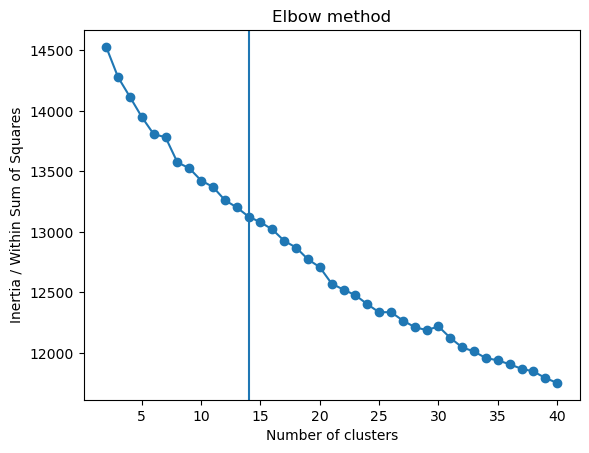

In [12]:
# STEP 6: DETERMINE NUMBER OF CLUSTERS

# Set seed for reproducible results
#np.random.seed(244)

# Create empty list to intertias (within cluster sum of squares)
inertias = []

# Test kmeans intertias/within ss for 2-40 clusters
# Random state needed for reproducible results
for k in range(2,41):
  kmeans = KMeans(n_clusters=k, max_iter=200, random_state=384)
  kmeans.fit(normalised_vectors)
  inertias.append(kmeans.inertia_)

# Generate the elbow plot
plt.plot(range(2,41), inertias, marker='o')
plt.axvline(x = 14) # Guiding line for selected number of clusters
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia / Within Sum of Squares')
plt.show() 

In [58]:
# STEP 6: GENERATE CLUSTERS WITH KMEANS

# Define number of clusters based on elbow plot
n_clusters = 14

# Generate kmeans clusters and labels
# Random state needed for stable clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=1992)
kmeans.fit(normalised_vectors)
labels = kmeans.labels_

# Create a df with the cluster number for each token contained in the model
token_cluster_all = pd.DataFrame({"token": valid_tokens, "cluster": labels})

# Check
token_cluster_all


,token,cluster
0,breite,8
1,forstwege,3
2,pfade,10
3,halber,12
4,strecke,10
...,...,...
16358,marienthal,11
16359,höhe,8
16360,sonne,12
16361,fast,8


In [59]:
# STEP 6: SAVE OUTPUTS FOR RQ3

pickle.dump(token_cluster_all, open("./processing/token_cluster_all.p", "wb"))

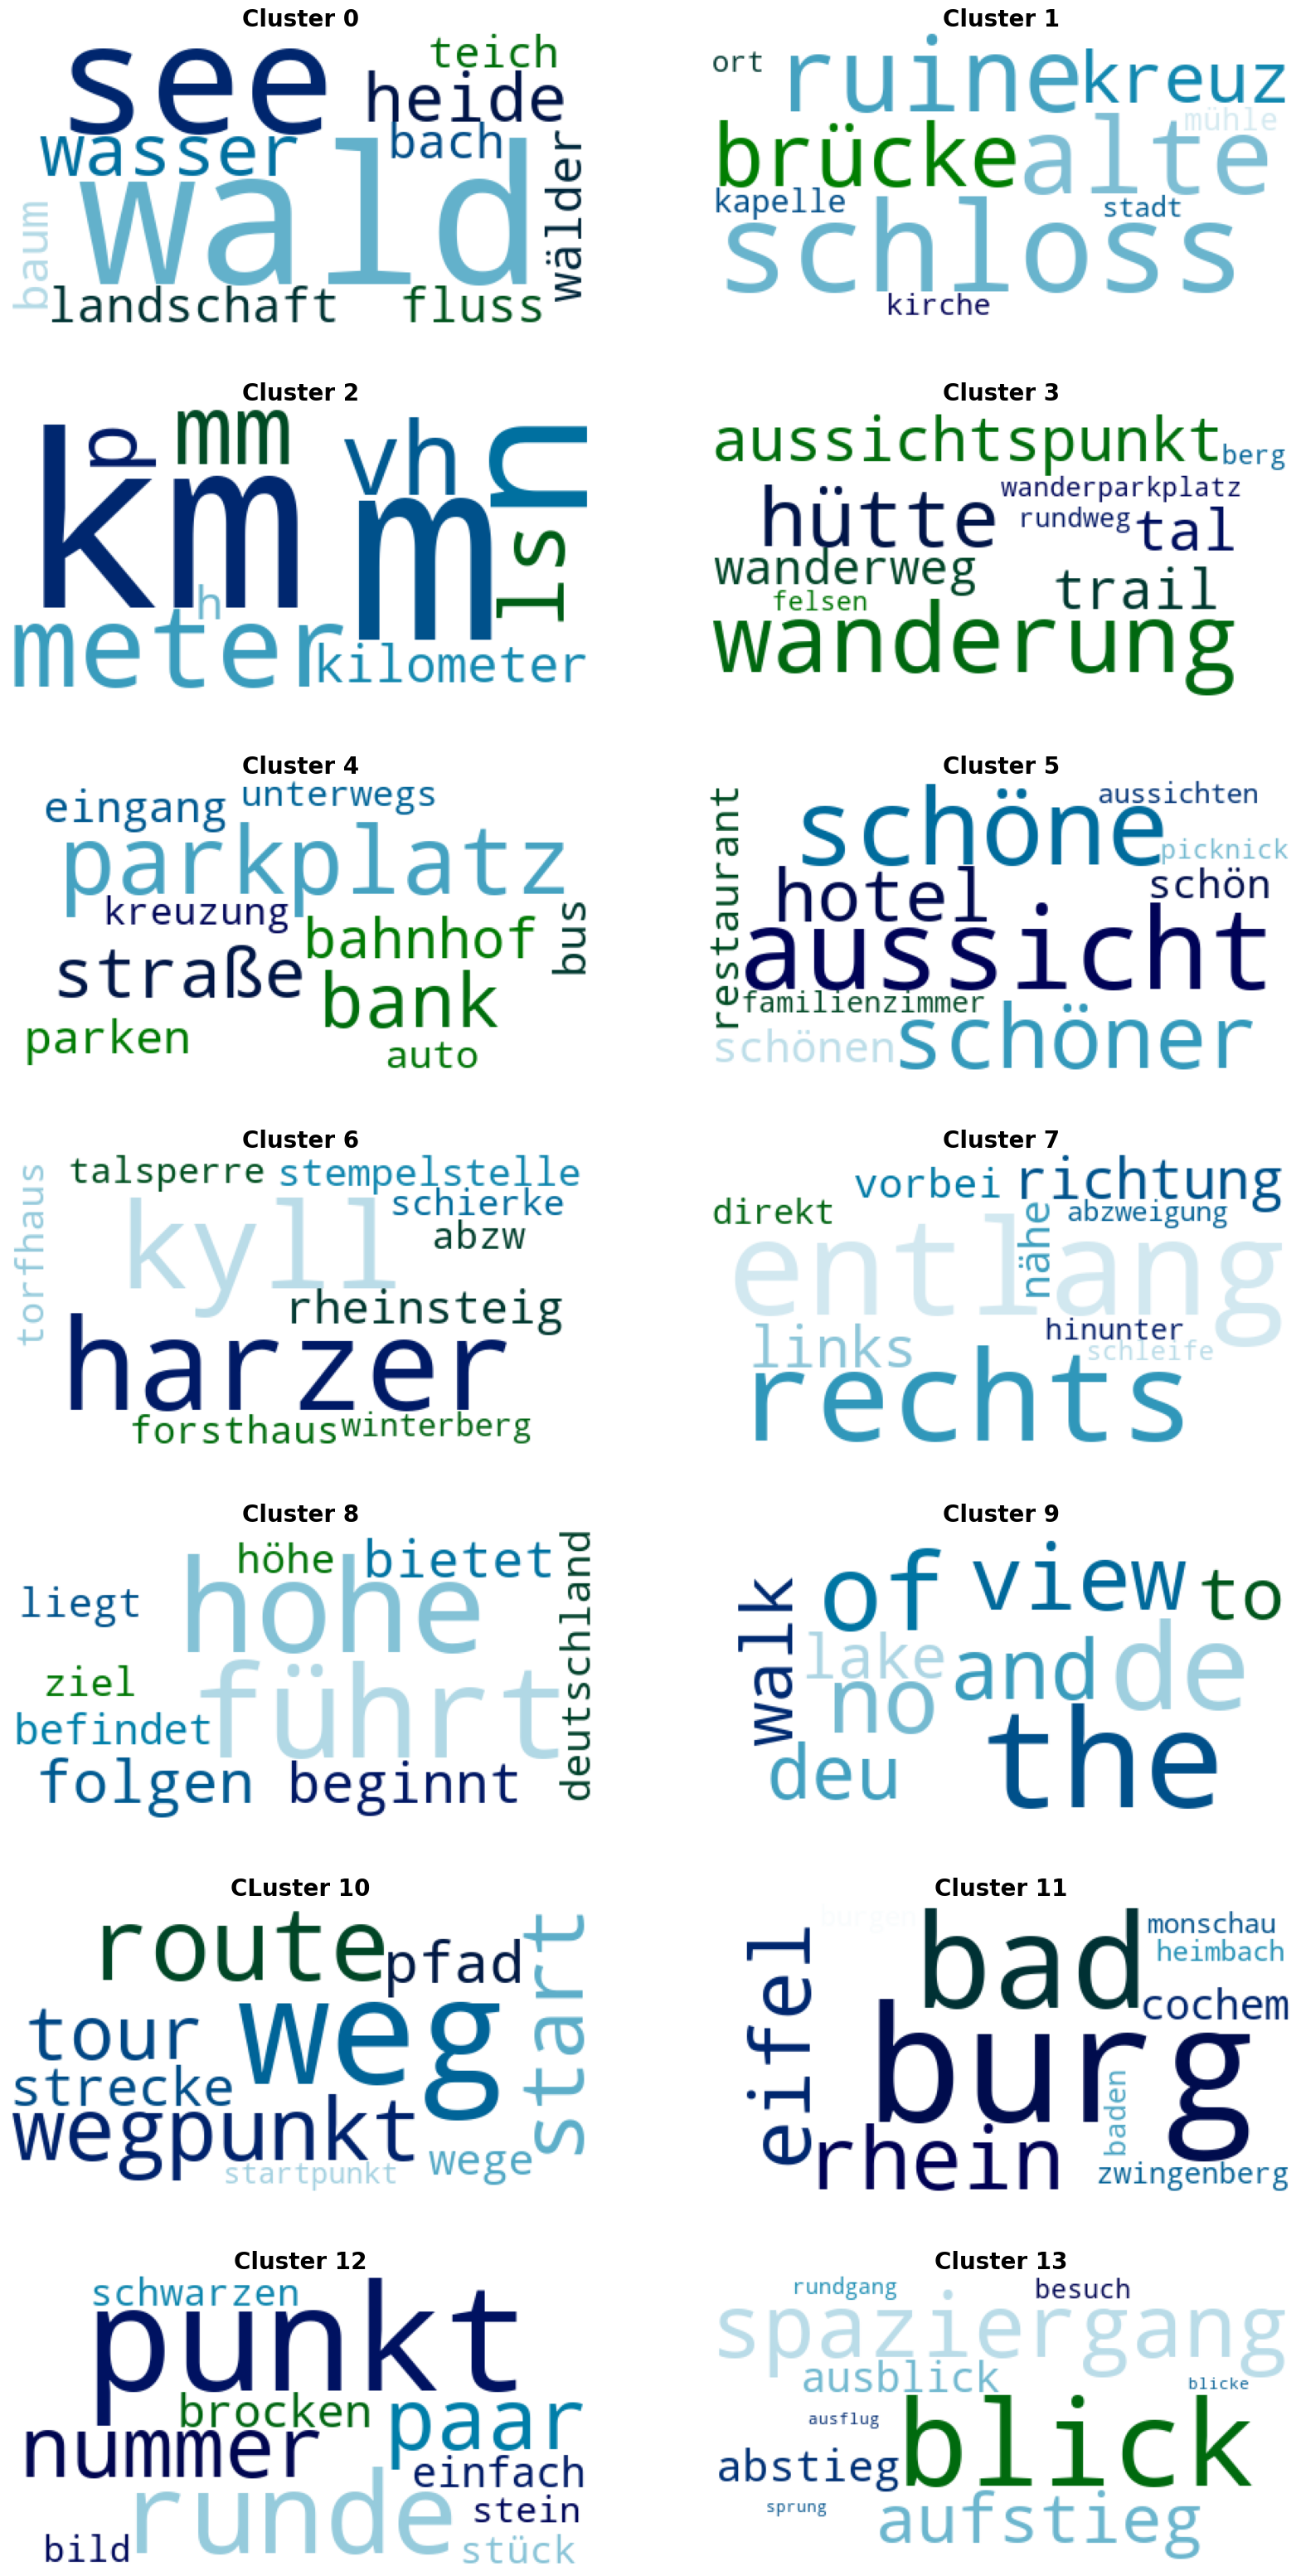

In [62]:
# STEP 6: CLUSTER WORD CLOUDS

# Create a function to count the token frequencies for each cluster 
def get_cluster_freq(df, clus_num):
    token_list = df.loc[df["cluster"] == clus_num, "token"]
    delimiter = " " 
    join_str = delimiter.join(token_list)
    freqs = Counter(join_str.split())
    return freqs

# Create empty lists for storing the word cloud plots 
all_wc = []

# For each cluster number use the get_cluster_freq function to get token frequencies,
# input those frequencies into the WordCloud generator and append each wc to list
# IMPORTANT: I HAVE LIMITED TO SHOW TOP 10 TOKENS IN EACH CLUSTER
for clus_num in range(14):  
    freqs = get_cluster_freq(token_cluster_all, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='ocean', 
                   max_words=10).generate_from_frequencies(freqs)
    all_wc.append(wc)

# Create custom titles
all_titles = ["Cluster 0", "Cluster 1", 
              "Cluster 2",  "Cluster 3", 
              "Cluster 4", "Cluster 5", 
              "Cluster 6", "Cluster 7", 
              "Cluster 8", "Cluster 9",
              "CLuster 10", "Cluster 11",
              "Cluster 12", "Cluster 13",
              "Cluster 14", "Cluster 15"]

old_titles = ["Cluster 0 - Distances/Units", "Cluster 1 - Religion? (spiritual CES?)", 
              "Cluster 2 - Odd mix...",  "Cluster 3 - Nature Words", 
              "Cluster 4 - Placenames", "Cluster 5 - Harz placenames", 
              "Cluster 6 - Trail/Route Words", "Cluster 7 - Placemames", 
              "Cluster 8 - Old things (heritage CES?)", "Cluster 9 - Trail/Route Words",
              "Cluster 10 - Directions/Transportation", "Cluster 11 - Directions"]


# Create a figure with subplots
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 40))
axes = axes.flatten()

# Iterate through word clouds and titles to plot
for i, (wc, title) in enumerate(zip(all_wc, all_titles)):
    axes[i].imshow(wc)
    axes[i].axis('off')
    axes[i].set_title(title, fontsize=20, fontweight="bold")

# Display final figure
plt.show()

